# Introduction to forecasting with [sktime](https://github.com/alan-turing-institute/sktime)

In this notebook we test some of the forecasting methods offered by [sktime](https://github.com/alan-turing-institute/sktime) for the Bassel temperature dataset. The code is a (1-1) adaptation of the (https://github.com/alan-turing-institute/sktime/blob/master/examples/01_forecasting.ipynb)[introductory notebook] from sktmie examples. We re commend to go to this reference to get a better undertanding of sktime forecasting module.

## Prepare Notebook

In [1]:
# Main data packages. 
import numpy as np
import pandas as pd
# Data Viz. 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [2]:
import sktime

print(sktime.__version__)

0.5.0


## Read Data

In [3]:
raw_df = pd.read_csv('../../data/basel_weather.csv')

data_df = raw_df.copy()

data_df = data_df.rename(columns={
    'Basel Temperature [2 m elevation corrected]': 'temperature', 
    'Basel Precipitation Total': 'precipitation', 
    'Basel Wind Speed [10 m]': 'wind_speed', 
    'Basel Wind Direction [10 m]': 'wind_direction'
    }
)

data_df = data_df.assign(
    timestamp = lambda x: pd.to_datetime(x['timestamp']), 
    date = lambda x: x['timestamp'].dt.date,
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofyear = lambda x: x['timestamp'].dt.dayofyear,
    hour = lambda x: x['timestamp'].dt.hour,
)

# Next, we aggregate by day. 
daily_data_df = data_df \
    .groupby(['date', 'year', 'month', 'day', 'dayofyear'], as_index=False)\
    .agg({'temperature': np.mean}) \
    .assign(date = lambda x: pd.to_datetime(x['date']))

daily_data_df.head()

,date,year,month,day,dayofyear,temperature
0,2008-01-01,2008,1,1,1,1.504620
1,2008-01-02,2008,1,2,2,-0.716971
2,2008-01-03,2008,1,3,3,1.312195
3,2008-01-04,2008,1,4,4,3.012195
4,2008-01-05,2008,1,5,5,7.090529


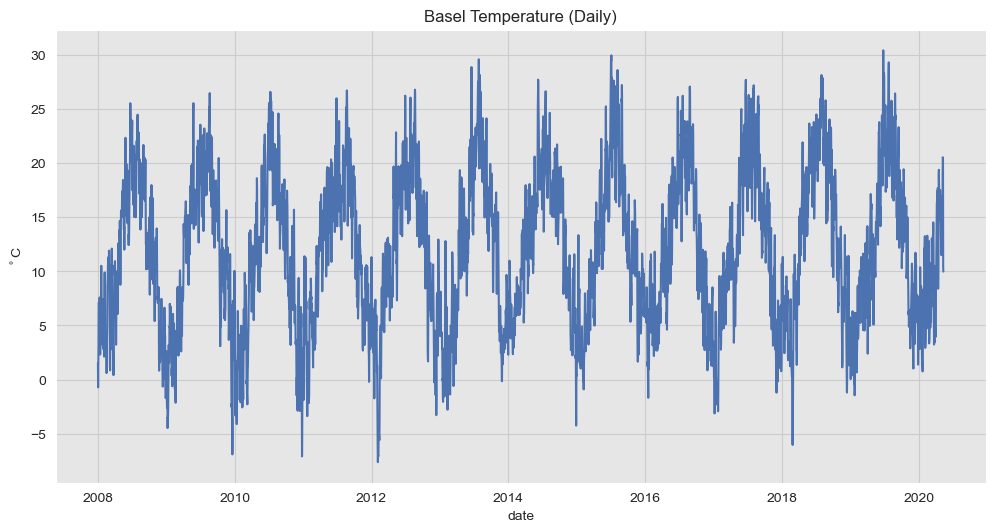

In [4]:
# Plot daily data. 
fig, ax = plt.subplots()
sns.lineplot(x='date', y='temperature', data=daily_data_df.reset_index(), ax=ax)
ax.set(title='Basel Temperature (Daily)', ylabel=r'$^\circ$C');

## Prepare Data

In [5]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon

y = daily_data_df['temperature']
# It is very miportant to add a `freq` value, otherwise the predict method will not work!
y.index= pd.DatetimeIndex(daily_data_df['date'], freq='D')

y_train, y_test = temporal_train_test_split(y, test_size=500)

fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2018-12-30', '2018-12-31', '2019-01-01', '2019-01-02',
               '2019-01-03', '2019-01-04', '2019-01-05', '2019-01-06',
               '2019-01-07', '2019-01-08',
               ...
               '2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06',
               '2020-05-07', '2020-05-08', '2020-05-09', '2020-05-10',
               '2020-05-11', '2020-05-12'],
              dtype='datetime64[ns]', name='date', length=500, freq='D', is_relative=False)

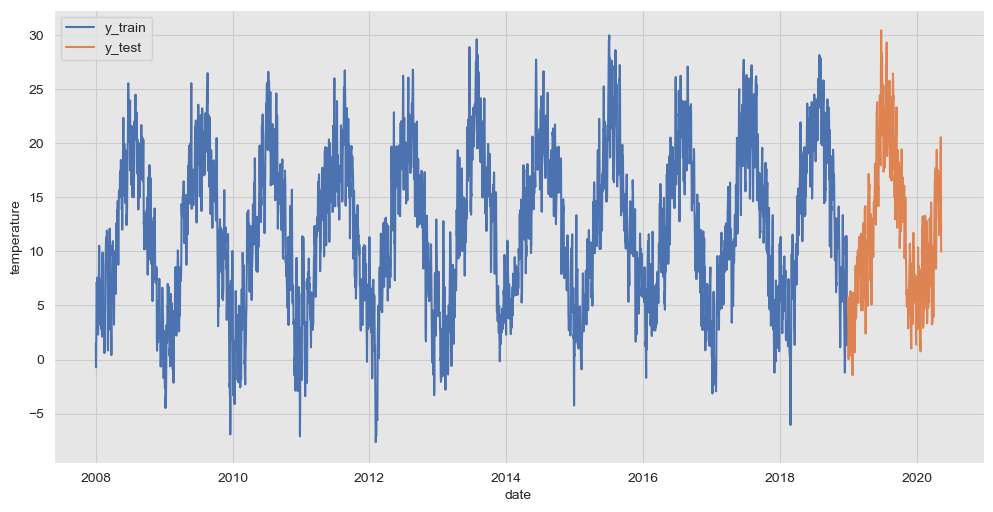

In [6]:
fig, ax = plt.subplots()
sns.lineplot(x=y_train.index, y=y_train, color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=y_test.index, y=y_test, color=sns_c[1], label='y_test', ax=ax);

## Forecastiing

### Seasonal Naive

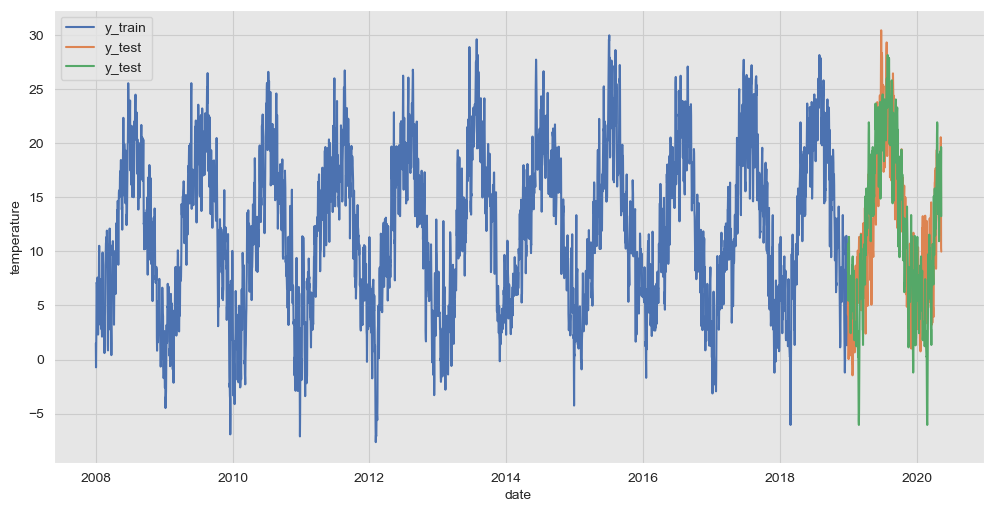

In [7]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy='last', sp=365)
forecaster.fit(y=y_train)
y_pred = forecaster.predict(fh=fh)

fig, ax = plt.subplots()
sns.lineplot(x=y_train.index, y=y_train, color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=y_test.index, y=y_test, color=sns_c[1], label='y_test', ax=ax)
sns.lineplot(x=y_pred.index, y=y_pred, color=sns_c[2], label='y_test', ax=ax);

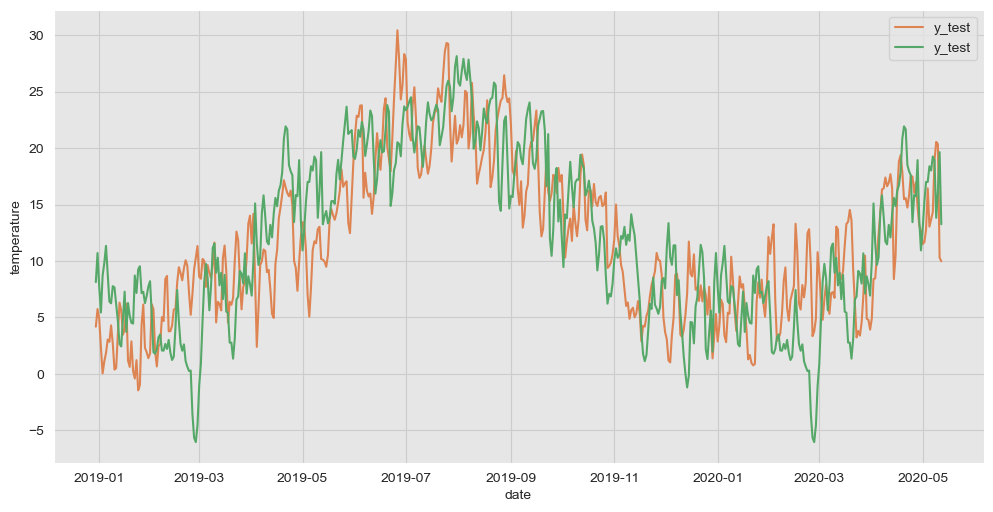

In [8]:
fig, ax = plt.subplots()
sns.lineplot(x=y_test.index, y=y_test, color=sns_c[1], label='y_test', ax=ax)
sns.lineplot(x=y_pred.index, y=y_pred, color=sns_c[2], label='y_test', ax=ax);

In [9]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true=y_test, y_pred=y_pred)

25.459567796912786

### Exponential Smoothing

/Users/juanitorduz/opt/anaconda3/envs/btsa/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


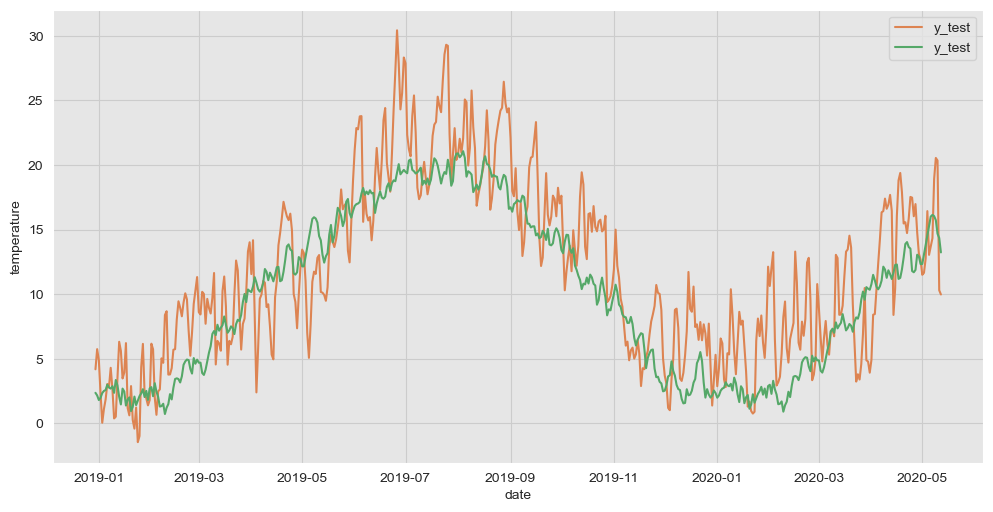

In [10]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

forecaster = ExponentialSmoothing(
    trend='add',
    seasonal='add',
    sp=365,
)
forecaster.fit(y=y_train)
y_pred = forecaster.predict(fh=fh)

fig, ax = plt.subplots()
sns.lineplot(x=y_test.index, y=y_test, color=sns_c[1], label='y_test', ax=ax)
sns.lineplot(x=y_pred.index, y=y_pred, color=sns_c[2], label='y_test', ax=ax)
mean_squared_error(y_true=y_test, y_pred=y_pred);

### ReducedRegression

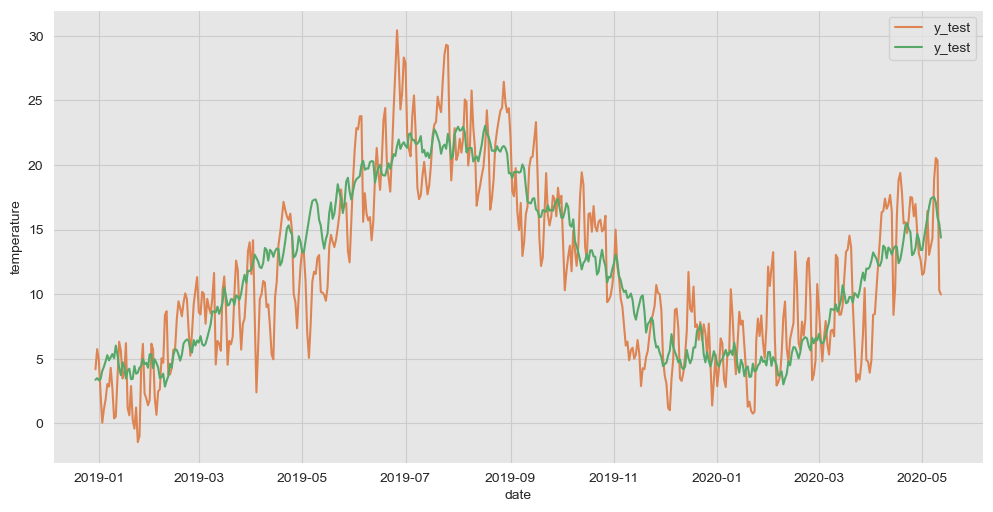

In [11]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.compose import ReducedRegressionForecaster

from sklearn.linear_model import ElasticNet

regressor = ElasticNet()

forecaster = TransformedTargetForecaster([
    ('deseasonalise', Deseasonalizer(model='additive', sp=365)),
    ('detrend', Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
    ('forecast', ReducedRegressionForecaster(regressor=regressor, window_length=7, strategy='recursive'))
])

forecaster.fit(y=y_train)
y_pred = forecaster.predict(fh=fh)

fig, ax = plt.subplots()
sns.lineplot(x=y_test.index, y=y_test, color=sns_c[1], label='y_test', ax=ax)
sns.lineplot(x=y_pred.index, y=y_pred, color=sns_c[2], label='y_test', ax=ax)
mean_squared_error(y_true=y_test, y_pred=y_pred);